In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformer_lens import HookedTransformer, HookedTransformerConfig
from tqdm.notebook import tqdm
import plotly.express as px
from sklearn.decomposition import PCA

# Set seeds for reproducibility
torch.manual_seed(999)
np.random.seed(999)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
P = 113
TRAIN_FRACTION = 0.3

def make_dataset(p, fraction):
    pairs = [(i, j, (i + j) % p) for i in range(p) for j in range(p)]
    data = torch.tensor(pairs).to(device)

    perm = torch.randperm(len(data))
    data = data[perm]
    
    cutoff = int(len(data) * fraction)
    train_data = data[:cutoff]
    test_data = data[cutoff:]
    
    return train_data, test_data

train_data_raw, test_data_raw = make_dataset(P, TRAIN_FRACTION)

def prepare_batch(raw_data, batch_size=None):
    if batch_size is None:
        batch_data = raw_data
    else:
        indices = torch.randint(0, len(raw_data), (batch_size,))
        batch_data = raw_data[indices]
        
    inputs = torch.cat([batch_data[:, :2], torch.full((len(batch_data), 1), P, device=device)], dim=1)
    targets = batch_data[:, 2] 
    return inputs, targets

print(f"Train size: {len(train_data_raw)}, Test size: {len(test_data_raw)}")

Train size: 3830, Test size: 8939


In [ ]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type = None, # No LayerNorm
    d_vocab = P + 1, # 0..112 are numbers, 113 is '='
    d_vocab_out = P, # Output only numbers 0..112
    n_ctx = 3,
    init_weights = True,
    device = device,
    seed = 999
)

model = HookedTransformer(cfg)

# Freeze biases as requested [cite: 170]
for name, param in model.named_parameters():
    if "b_" in name: # Biases usually start with b_ in TransformerLens
        param.requires_grad = False
        param.data.zero_() 

print("Model initialized. Biases frozen.")

Model initialized. Biases frozen.


  0%|          | 0/15000 [00:00<?, ?it/s]

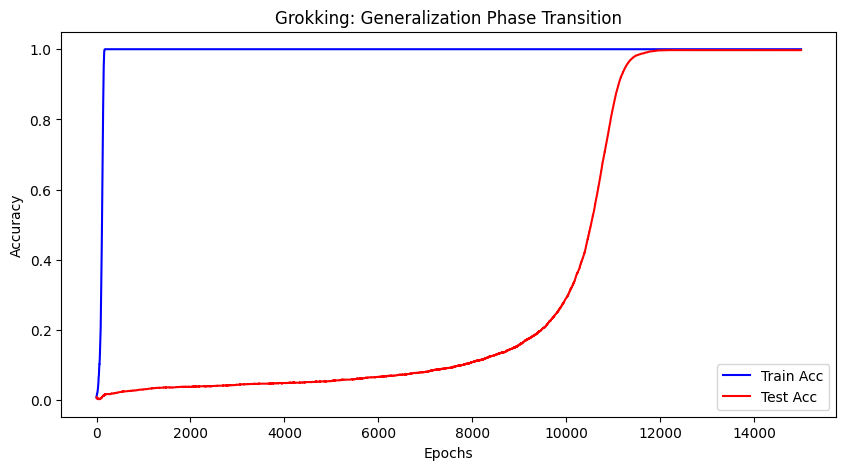

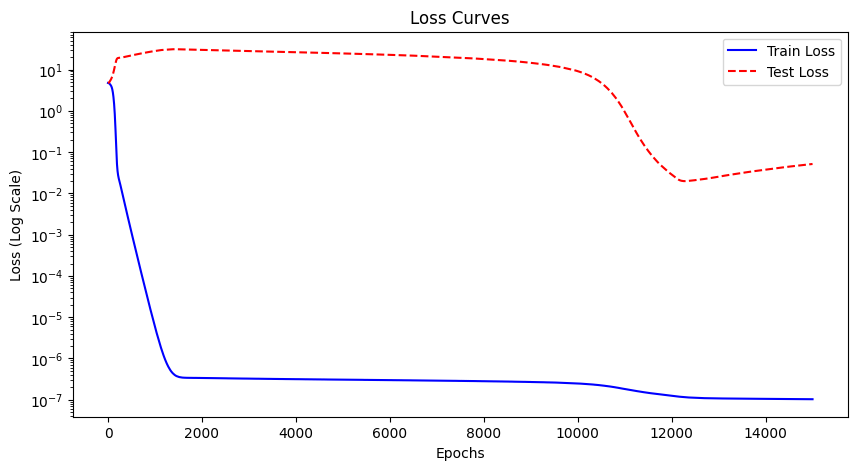

In [ ]:
lr = 1e-3
wd = 1.0
betas = (0.9, 0.98)
num_epochs = 15000
batch_size = 128 

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

def loss_fn(logits, labels):
    # Logits shape: [Batch, Seq, Vocab]. We want last seq pos.
    last_logits = logits[:, -1, :] 
    last_logits = last_logits.to(torch.float64)
    log_probs = F.log_softmax(last_logits, dim=-1)
    loss = F.nll_loss(log_probs, labels)
    return loss.to(torch.float32)

pbar = tqdm(range(num_epochs))

for epoch in pbar:
    model.train()
    inputs, labels = prepare_batch(train_data_raw) 
    
    logits = model(inputs)
    loss = loss_fn(logits, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    with torch.no_grad():
        preds = logits[:, -1, :].argmax(dim=-1)
        train_acc = (preds == labels).float().mean().item()
        train_accs.append(train_acc)
        
        test_inputs, test_labels = prepare_batch(test_data_raw)
        test_logits = model(test_inputs)
        test_loss = loss_fn(test_logits, test_labels)
        test_losses.append(test_loss.item())
        test_preds = test_logits[:, -1, :].argmax(dim=-1)
        test_acc = (test_preds == test_labels).float().mean().item()
        test_accs.append(test_acc)
        
    if epoch % 100 == 0:
        pbar.set_description(f"E:{epoch} | TrL:{loss.item():.4f} | TeL:{test_loss.item():.4f} | TrA:{train_acc:.2f} | TeA:{test_acc:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Acc", color="blue")
plt.plot(test_accs, label="Test Acc", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Grokking: Generalization Phase Transition")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(test_losses, label="Test Loss", color="red", linestyle="--")
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Loss (Log Scale)")
plt.title("Loss Curves")
plt.legend()
plt.show()

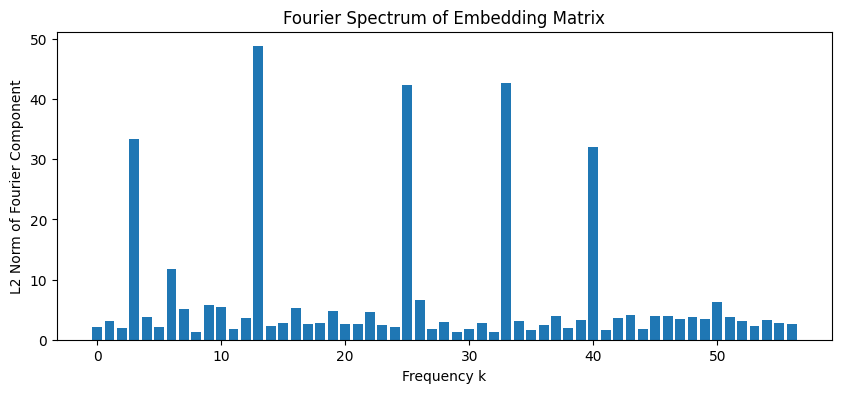

Top Frequencies: tensor([13, 33, 25,  3, 40,  6])


In [ ]:
W_E = model.W_E[:-1, :].detach().cpu() # Shape [113, 128]

# Perform DFT along the vocab dimension (P=113)
# fft(input, dim=0)
W_E_fft = torch.fft.fft(W_E, dim=0)
W_E_fft_norm = torch.norm(W_E_fft, dim=1) # L2 norm across d_model

# Plot
freqs = range(len(W_E_fft_norm))
plt.figure(figsize=(10, 4))
plt.bar(freqs[:P//2+1], W_E_fft_norm[:P//2+1])
plt.xlabel("Frequency k")
plt.ylabel("L2 Norm of Fourier Component")
plt.title("Fourier Spectrum of Embedding Matrix")
plt.show()

top_k = torch.topk(W_E_fft_norm[:P//2+1], 6) 

print("Top Frequencies:", top_k.indices)
key_freq = top_k.indices[0].item()

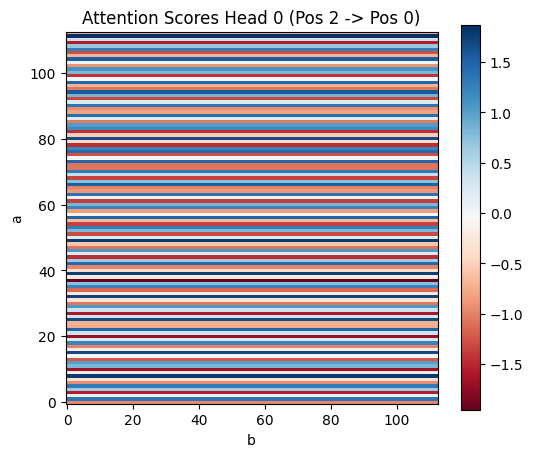

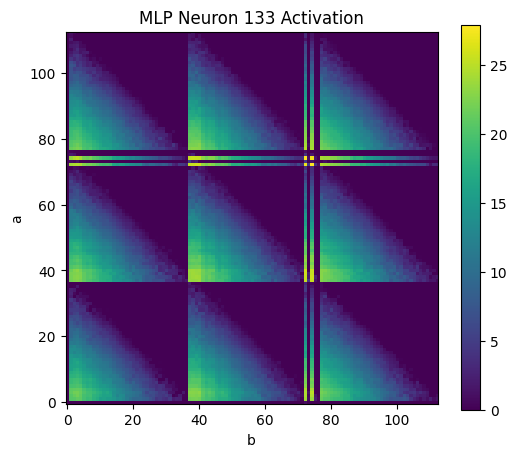

In [ ]:
def get_activations(inputs):
    _, cache = model.run_with_cache(inputs)
    return cache

# We'll sweep over all possible a, b to make a grid
grid_inputs = torch.tensor([[i, j, P] for i in range(P) for j in range(P)]).to(device)

cache = get_activations(grid_inputs)

# Analyze Attention Scores (Head 0 for example)
# Attention scores for query at pos 2 (the '=') attending to keys at pos 0 (a) or 1 (b)
# Shape: [Batch, Head, Query, Key]
attn_scores = cache["blocks.0.attn.hook_attn_scores"]
# Look at Head 0, Query pos 2, Key pos 0
head_idx = 0
attn_map_0 = attn_scores[:, head_idx, 2, 0].reshape(P, P).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(attn_map_0, origin='lower', cmap='RdBu')
plt.title(f"Attention Scores Head {head_idx} (Pos 2 -> Pos 0)")
plt.colorbar()
plt.xlabel("b")
plt.ylabel("a")
plt.show()

# Check MLP Activations
# Shape: [Batch, Seq, d_mlp]
mlp_acts = cache["blocks.0.mlp.hook_post"][:, 2, :].detach().cpu() # At pos 2
# Pick a neuron that seems active
neuron_idx = mlp_acts.var(dim=0).argmax().item()
neuron_map = mlp_acts[:, neuron_idx].reshape(P, P)

plt.figure(figsize=(6, 5))
plt.imshow(neuron_map, origin='lower', cmap='viridis')
plt.title(f"MLP Neuron {neuron_idx} Activation")
plt.colorbar()
plt.xlabel("b")
plt.ylabel("a")
plt.show()

In [ ]:
def ablate_frequencies(model, remove_freqs, verbose=False):
    W_E_orig = model.W_E.data.clone()
    W_E_nums = W_E_orig[:-1, :] # Tokens 0..112
    
    W_fft = torch.fft.fft(W_E_nums, dim=0)
    
    if verbose:
        print(f"Total Energy before: {W_fft.norm().item():.2f}")
    
    for k in remove_freqs:
        k = int(k)
        W_fft[k, :] = 0
        if k != 0:
            W_fft[P-k, :] = 0
            
    if verbose:
        print(f"Total Energy after: {W_fft.norm().item():.2f}")

    W_E_ablated = torch.fft.ifft(W_fft, dim=0).real
    
    model.W_E.data[:-1, :] = W_E_ablated
    
    test_in, test_lbl = prepare_batch(test_data_raw)
    with torch.no_grad():
        logits = model(test_in)[:, -1, :]
        acc = (logits.argmax(dim=-1) == test_lbl).float().mean().item()
        
    model.W_E.data = W_E_orig
    
    return acc

key_freqs_indices = [3, 6, 13, 25, 33, 40] 

key_freqs = set()
for k in key_freqs_indices:
    key_freqs.add(k)
    key_freqs.add(P - k)

print(f"Key Frequencies: {key_freqs}")

acc_no_keys = ablate_frequencies(model, key_freqs, verbose=True)
print(f"Accuracy after removing Key Frequencies: {acc_no_keys:.4f}")

all_freqs = set(range(P))
freqs_to_keep = key_freqs.union({0}) 
noise_freqs = all_freqs - freqs_to_keep

acc_no_noise = ablate_frequencies(model, noise_freqs, verbose=True)
print(f"Accuracy after removing Noise: {acc_no_noise:.4f}")

Corrected Key Frequencies: {33, 3, 100, 6, 40, 73, 107, 13, 110, 80, 88, 25}
Total Energy before: 133.10
Total Energy after: 34.13
Accuracy after removing Key Frequencies: 0.0097
Total Energy before: 133.10
Total Energy after: 128.67
Accuracy after removing Noise: 0.9041


In [ ]:
def plot_pca_for_frequency(model, freq_index):
    W_E_np = model.W_E[:-1, :].detach().cpu().numpy()
    
    W_tensor = torch.tensor(W_E_np)
    W_fft = torch.fft.fft(W_tensor, dim=0)
    
    mask = torch.zeros_like(W_fft)
    
    mask[freq_index, :] = W_fft[freq_index, :]
    if freq_index != 0:
        mask[P-freq_index, :] = W_fft[P-freq_index, :]
        
    W_filtered = torch.fft.ifft(mask, dim=0).real.numpy()
    
    pca = PCA(n_components=2)
    pca_res = pca.fit_transform(W_filtered)
    
    df = pd.DataFrame({
        'x': pca_res[:, 0], 
        'y': pca_res[:, 1], 
        'Value': range(P),
    })
    
    fig = px.scatter(
        df, x='x', y='y', color='Value', 
        title=f"PCA of Isolated Frequency k={freq_index}",
        color_continuous_scale='hsv',
        width=600, height=600
    )
    fig.show()

dominant_freq = 33
plot_pca_for_frequency(model, dominant_freq)

Training for Progress Measures...


  0%|          | 0/15000 [00:00<?, ?it/s]

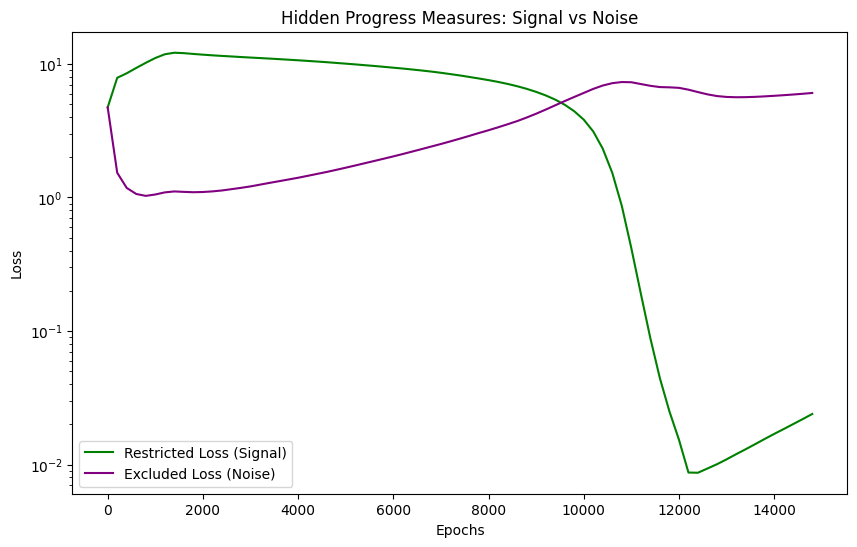

In [ ]:
def filter_logits_by_freq(logits, keep_freqs):
    logits_fft = torch.fft.fft(logits.float(), dim=-1)
    
    mask = torch.zeros_like(logits_fft, dtype=torch.bool)
    for k in keep_freqs:
        mask[:, k] = True
        
    logits_fft_masked = torch.where(mask, logits_fft, torch.zeros_like(logits_fft))
    
    logits_filtered = torch.fft.ifft(logits_fft_masked, dim=-1).real
    return logits_filtered.to(device)


model_prog = HookedTransformer(cfg)
for name, param in model_prog.named_parameters():
    if "b_" in name:
        param.requires_grad = False
        param.data.zero_()

optimizer_prog = optim.AdamW(model_prog.parameters(), lr=lr, weight_decay=wd, betas=betas)

restricted_losses = []
excluded_losses = []
epochs_log = []

final_key_freqs = key_freqs 

for epoch in tqdm(range(15000)):
    model_prog.train()
    inputs, labels = prepare_batch(train_data_raw)
    logits = model_prog(inputs)
    loss = loss_fn(logits, labels)
    
    optimizer_prog.zero_grad()
    loss.backward()
    optimizer_prog.step()
    
    if epoch % 200 == 0:
        model_prog.eval()
        with torch.no_grad():
            test_in, test_lbl = prepare_batch(test_data_raw)
            test_logits = model_prog(test_in)[:, -1, :P]
            res_logits = filter_logits_by_freq(test_logits, final_key_freqs)
            res_loss = F.cross_entropy(res_logits, test_lbl).item()
            
            train_logits_snap = model_prog(inputs)[:, -1, :P]
            
            all_fs = set(range(P))
            exc_fs = all_fs - final_key_freqs
            exc_logits = filter_logits_by_freq(train_logits_snap, exc_fs)
            exc_loss = F.cross_entropy(exc_logits, labels).item()
            
        restricted_losses.append(res_loss)
        excluded_losses.append(exc_loss)
        epochs_log.append(epoch)

plt.figure(figsize=(10, 6))
plt.plot(epochs_log, restricted_losses, label="Restricted Loss (Signal)", color="green")
plt.plot(epochs_log, excluded_losses, label="Excluded Loss (Noise)", color="purple")
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Hidden Progress Measures: Signal vs Noise")
plt.legend()
plt.show()

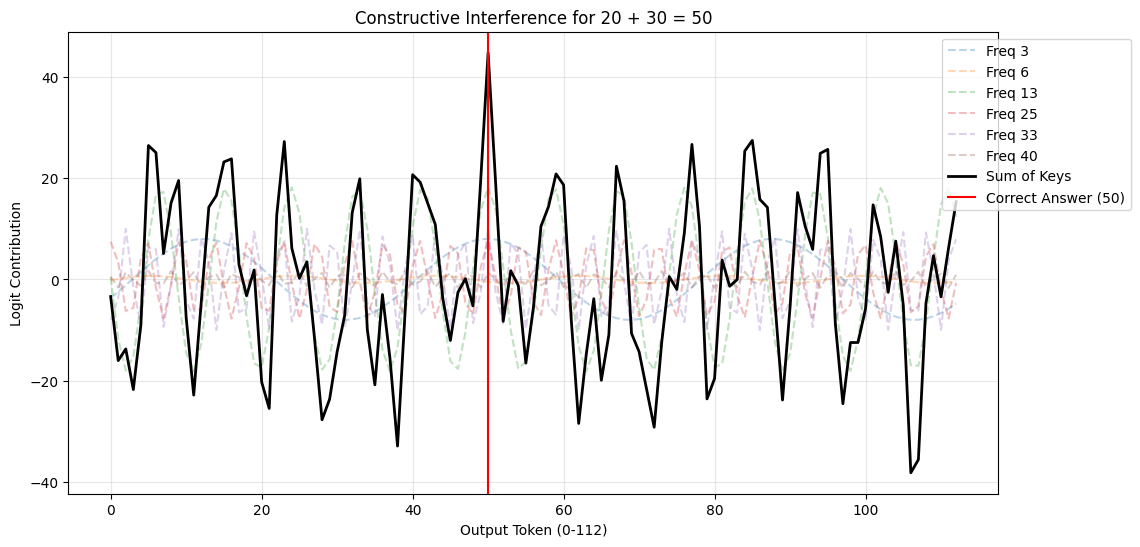

In [ ]:

a_val, b_val = 20, 30
target = (a_val + b_val) % P

model.eval()
input_tensor = torch.tensor([[a_val, b_val, P]]).to(device) # Shape [1, 3]

with torch.no_grad():
    full_logits = model(input_tensor)[0, -1, :P]
    
    freq_contributions = []
    labels = []
    
    for k in list(key_freqs_indices):
        single_freq_set = {k, P-k}       
        contrib = filter_logits_by_freq(full_logits.unsqueeze(0), single_freq_set)[0]
        freq_contributions.append(contrib.cpu().numpy())
        labels.append(f"Freq {k}")

plt.figure(figsize=(12, 6))

for i, contrib in enumerate(freq_contributions):
    plt.plot(contrib, alpha=0.3, label=labels[i], linestyle='--')

sum_key_logits = np.sum(freq_contributions, axis=0)
plt.plot(sum_key_logits, color='black', linewidth=2, label="Sum of Keys")

plt.axvline(target, color='red', linestyle='-', label=f"Correct Answer ({target})")

plt.xlabel("Output Token (0-112)")
plt.ylabel("Logit Contribution")
plt.title(f"Constructive Interference for {a_val} + {b_val} = {target}")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, alpha=0.3)
plt.show()

Initializing Subtraction Experiment...
Subtraction Train Size: 3830


  0%|          | 0/20000 [00:00<?, ?it/s]

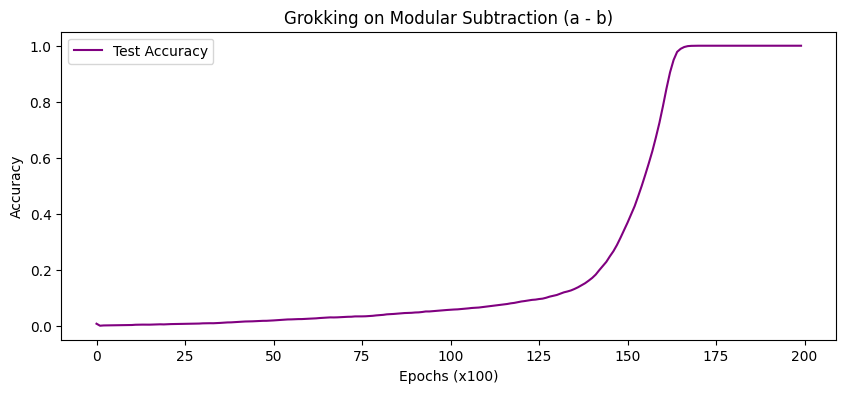

In [ ]:
def make_subtraction_dataset(p, fraction):
    pairs = [(i, j, (i - j) % p) for i in range(p) for j in range(p)]
    data = torch.tensor(pairs).to(device)
    
    perm = torch.randperm(len(data))
    data = data[perm]
    
    cutoff = int(len(data) * fraction)
    return data[:cutoff], data[cutoff:]

train_sub, test_sub = make_subtraction_dataset(P, TRAIN_FRACTION)
print(f"Subtraction Train Size: {len(train_sub)}")

model_sub = HookedTransformer(cfg)
for name, param in model_sub.named_parameters():
    if "b_" in name:
        param.requires_grad = False
        param.data.zero_()

optimizer_sub = optim.AdamW(model_sub.parameters(), lr=lr, weight_decay=wd, betas=betas)
num_epochs_sub = 15000+5000 

pbar = tqdm(range(num_epochs_sub))
sub_losses = []
sub_test_accs = []

for epoch in pbar:
    model_sub.train()
    inputs, labels = prepare_batch(train_sub)
    
    logits = model_sub(inputs)
    loss = loss_fn(logits, labels)
    
    optimizer_sub.zero_grad()
    loss.backward()
    optimizer_sub.step()
    
    sub_losses.append(loss.item())
    
    if epoch % 100 == 0:
        with torch.no_grad():
            test_inputs, test_labels = prepare_batch(test_sub)
            test_logits = model_sub(test_inputs)
            acc = (test_logits[:, -1, :].argmax(dim=-1) == test_labels).float().mean().item()
            sub_test_accs.append(acc)
        pbar.set_description(f"Subtr Epoch {epoch} | Loss: {loss.item():.4f} | Test Acc: {acc:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(sub_test_accs, label="Test Accuracy", color="purple")
plt.title("Grokking on Modular Subtraction (a - b)")
plt.xlabel("Epochs (x100)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Dominant Subtraction Frequency: 14


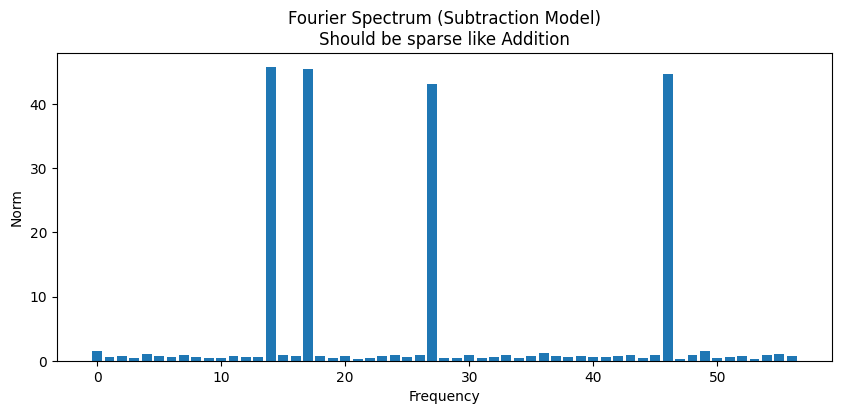

Neuron 141 tracks freq 14 (Correlation: 0.336)


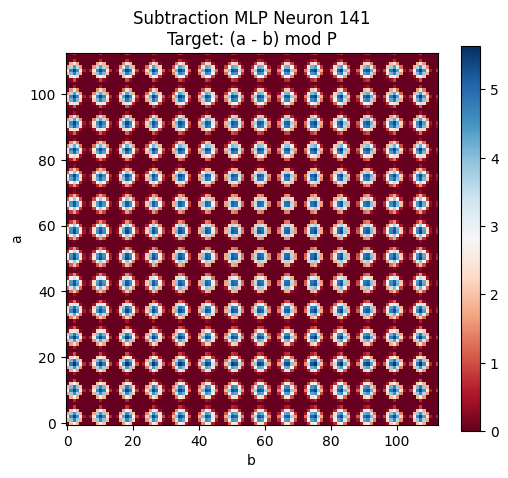

In [30]:
W_E_sub = model_sub.W_E[:-1, :].detach().cpu()
W_E_fft_sub = torch.fft.fft(W_E_sub, dim=0)
norms_sub = torch.norm(W_E_fft_sub, dim=1)

top_freq_sub = torch.argmax(norms_sub[1:P//2]).item() + 1
print(f"Dominant Subtraction Frequency: {top_freq_sub}")

plt.figure(figsize=(10, 4))
plt.bar(range(P//2+1), norms_sub[:P//2+1])
plt.title("Fourier Spectrum (Subtraction Model)")
plt.xlabel("Frequency")
plt.ylabel("Norm")
plt.show()

grid_inputs = torch.tensor([[i, j, P] for i in range(P) for j in range(P)]).to(device)
_, cache_sub = model_sub.run_with_cache(grid_inputs)

mlp_acts_sub = cache_sub["blocks.0.mlp.hook_post"][:, 2, :].detach().cpu()

a_grid = np.repeat(np.arange(P), P)
b_grid = np.tile(np.arange(P), P)
angle = 2 * np.pi * top_freq_sub / P

target_wave = np.cos(angle * (a_grid - b_grid))

corrs = []
for i in range(mlp_acts_sub.shape[1]):
    neuron = mlp_acts_sub[:, i].numpy()
    c = np.corrcoef(neuron, target_wave)[0, 1]
    corrs.append(c)

best_neuron = np.argmax(corrs)
print(f"Neuron {best_neuron} tracks freq {top_freq_sub} (Correlation: {max(corrs):.3f})")

neuron_map = mlp_acts_sub[:, best_neuron].reshape(P, P)

plt.figure(figsize=(6, 5))
plt.imshow(neuron_map, origin='lower', cmap='RdBu')
plt.title(f"Subtraction MLP Neuron {best_neuron}\nTarget: (a - b) mod P")
plt.colorbar()
plt.xlabel("b")
plt.ylabel("a")
plt.show()

Starting Geometry Analysis Run...


  0%|          | 0/15001 [00:00<?, ?it/s]


Computing Hessian Eigenvalues at Epoch 500...
Top Eigs: [0.9928890466690063, 0.6570307016372681, 0.6398788094520569]...

Computing Hessian Eigenvalues at Epoch 10000...
Top Eigs: [0.000351626513293013, 0.0002283412468386814, 0.000199856745894067]...

Computing Hessian Eigenvalues at Epoch 15000...
Top Eigs: [0.00011384553363313898, 6.66648629703559e-05, 4.650694609154016e-05]...


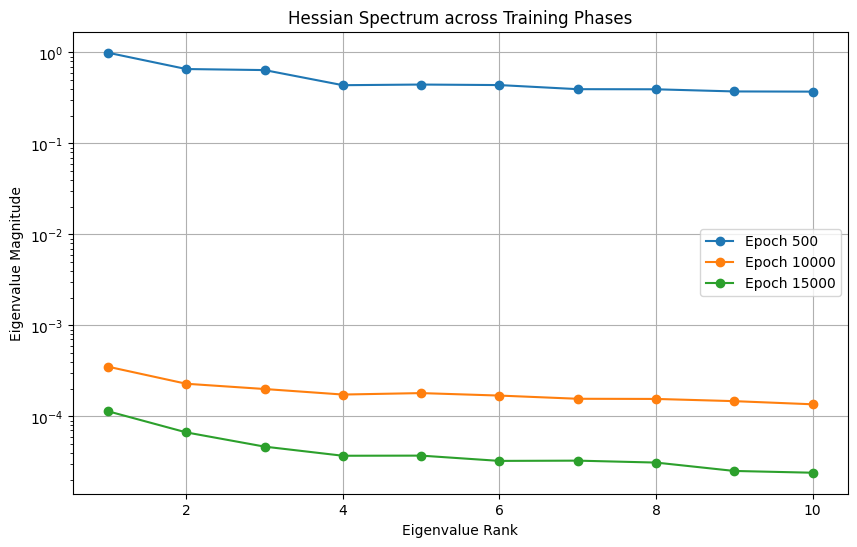


Top 5 Eigenvalues per Phase:
Phase 500: [0.99, 0.66, 0.64, 0.44, 0.44]
Phase 10000: [0.0, 0.0, 0.0, 0.0, 0.0]
Phase 15000: [0.0, 0.0, 0.0, 0.0, 0.0]


In [24]:
def get_top_k_eigenvalues(model, data_loader, top_k=10, num_iters=20):
    model.eval()
    
    inputs, targets = next(iter(data_loader)) 
    
    params = [p for p in model.parameters() if p.requires_grad]
    
    logits = model(inputs)
    loss = loss_fn(logits, targets)
    grads = torch.autograd.grad(loss, params, create_graph=True)
    
    flat_grad = torch.cat([g.reshape(-1) for g in grads])
    
    eigenvalues = []
    eigenvectors = []
    
    for k in range(top_k):
        v = torch.randn_like(flat_grad)
        v /= v.norm()
        
        for _ in range(num_iters):
            for prev_v in eigenvectors:
                v = v - torch.dot(v, prev_v) * prev_v
            
            v_norm = v.norm()
            if v_norm > 1e-6:
                v /= v_norm
            
            v.requires_grad = True
            grad_v_product = torch.dot(flat_grad, v)
            Hv = torch.autograd.grad(grad_v_product, params, retain_graph=True)
            
            Hv = torch.cat([g.reshape(-1) for g in Hv])
            
            v = Hv / (Hv.norm() + 1e-6)
            v = v.detach()
            
        grad_v_product = torch.dot(flat_grad, v)
        Hv = torch.autograd.grad(grad_v_product, params, retain_graph=True)
        Hv = torch.cat([g.contiguous().reshape(-1) for g in Hv])
        
        curr_eig = torch.dot(v, Hv).item()
        
        eigenvalues.append(curr_eig)
        eigenvectors.append(v)
        
    return eigenvalues

model_geo = HookedTransformer(cfg)
for name, param in model_geo.named_parameters():
    if "b_" in name:
        param.requires_grad = False
        param.data.zero_()

optimizer_geo = optim.AdamW(model_geo.parameters(), lr=lr, weight_decay=wd, betas=betas)

checkpoints = [500, 10000, 15000] 
results = {}

full_train_loader = [(prepare_batch(train_data_raw, batch_size=len(train_data_raw)))]

pbar = tqdm(range(checkpoints[-1] + 1))

for epoch in pbar:
    model_geo.train()
    inputs, labels = prepare_batch(train_data_raw)
    logits = model_geo(inputs)
    loss = loss_fn(logits, labels)
    optimizer_geo.zero_grad()
    loss.backward()
    optimizer_geo.step()
    
    if epoch in checkpoints:
        print(f"\nComputing Hessian Eigenvalues at Epoch {epoch}...")
        eigs = get_top_k_eigenvalues(model_geo, full_train_loader, top_k=10)
        results[epoch] = eigs
        print(f"Top Eigs: {eigs[:3]}...") # Print top 3 to check

plt.figure(figsize=(10, 6))
for epoch, eigs in results.items():
    plt.plot(range(1, 11), eigs, marker='o', label=f'Epoch {epoch}')

plt.xlabel("Eigenvalue Rank")
plt.ylabel("Eigenvalue Magnitude")
plt.title("Hessian Spectrum across Training Phases")
plt.yscale('log') # Log scale is often helpful here
plt.legend()
plt.grid(True)
plt.show()

print("\nTop 5 Eigenvalues per Phase:")
for epoch, eigs in results.items():
    print(f"Phase {epoch}: {[round(e, 2) for e in eigs[:5]]}")